# CE-40957: Reinforcement Learning
## HW1

*Full name:* Mohammad Kalbasi

*Student number:* 401211028

In this notebook, you will learn about reinforcement learning and its implementation in OpenAI Gym environments. 


This notebook is intended to provide hands-on experience with implementing reinforcement learning algorithms and evaluating their performance. By working through the code and examples, you will gain a deeper understanding of how Q-learning and monte carlo method works and how it can be applied to real-world problems.

# 1. Q-learning

In [7]:
!pip install gym[toy_text]
import gym
import numpy as np
from tqdm import trange 
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"
clear_output()

## Gym OpenAI Environments
`gym` is a library developed by OpenAI that provides a suite of environments for developing and comparing reinforcement learning algorithms. Each environment has a well-defined observation space and action space, as well as a reset function that returns the environment to its initial state.

The main steps involved in training an agent in a `gym` environment are:

1. Initialize the environment
2. Reset the environment to its initial state
3. Take an action in the current state
4. Observe the new state and reward
5. Update the agent's policy based on the observed reward and new state
6. Repeat steps 3 to 5 until the environment returns a "done" signal

Once the agent has learned a good policy, it can be evaluated by running it in the environment for several episodes and measuring its average reward.

### FrozenLake environment
The `FrozenLake-v1` environment is a variant of the classic reinforcement learning problem where the agent must navigate a grid while avoiding obstacles. 

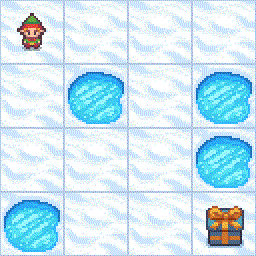


* **Observation Space:** The observation space of the environment is a grid representing the state of the lake.
* **Action Space:** The agent has four possible actions at each time step: move up, move down, move left, or move right.
* **Goal:** The goal of the agent is to reach the goal state while avoiding holes in the ice.
* **Reward:** Reach goal(G): +1 , Reach hole(H): 0 , Reach frozen(F): 0
* **Episode Termination:** The environment signals the end of an episode with a "done" signal.


In [ ]:
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4")
spec = gym.spec('FrozenLake-v1')

print(f"Action Space: {env.action_space}")
print(f"Observation Space: {env.observation_space}")
print(f"Max Episode Steps: {spec.max_episode_steps}")
print(f"Nondeterministic: {spec.nondeterministic}")
print(f"Reward Range: {env.reward_range}")
print(f"Reward Threshold: {spec.reward_threshold}\n")

Action Space: Discrete(4)
Observation Space: Discrete(16)
Max Episode Steps: 100
Nondeterministic: False
Reward Range: (0, 1)
Reward Threshold: 0.7



/usr/local/lib/python3.9/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.9/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


In [ ]:
Actions =  {0: 'LEFT', 
            1: 'DOWN',
            2: 'RIGHT',
            3: 'UP'}

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


UP --> DOWN --> LEFT


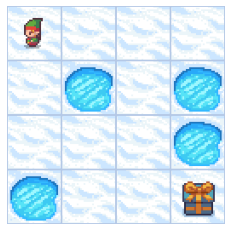

In [ ]:
# Be free to test!
# take random actions, and see how the agent moves

env.reset()

action_seq= []

for i in range(3):
  action_number = env.action_space.sample()
  action_seq.append(Actions[action_number])
  env.step(action_number)

print(' --> '.join(action_seq))
env_screen = env.render(mode = 'rgb_array')
plt.imshow(env_screen)
plt.axis('off');

## Q-Learning
Q-Learning is a model-free reinforcement learning algorithm that is used to find the optimal policy for an agent in an environment. It is based on the idea of updating an estimate of the optimal action-value function using the Bellman equation. The optimal action-value function is defined as the maximum expected reward that an agent can receive by taking an action a in a state s and following the optimal policy thereafter.

The action-value function Q(s,a) is updated iteratively as follows:

$$ Q(s,a) \leftarrow Q(s,a) + \alpha \left( r + \gamma \max_{a'} Q(s',a') - Q(s,a) \right) $$

where ‍‍‍‍‍`r` is the reward received after taking action a in state `s`, `s'` is the new state, $\gamma$ is the discount factor (a value between 0 and 1 that determines the importance of future rewards), and $\alpha$ is the learning rate (determines the step size at which the value function is updated).

In [ ]:

from tqdm import tqdm
action_space_all = np.array([0,1,2,3])

def q_learning(env, num_episodes, alpha, gamma,epsilon):
    # we added epsilon as input because we use epsilon greedy policy to learn Q matrix
    # Initialize the action-value function Q(s,a)
    r_list = [] # this two are two new outputs that we store len of episode and sum of rewards in each episode in them(reward is spare so output is either 0 or zero)
    episode_len_list = []
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    
    # Loop over each episode
    for episode in tqdm(range(num_episodes)):
        counter_len_episode = 0
        reward_episode = 0
        state = env.reset()

        # ==================================== Your Code (Begin) ====================================
        while(True):
          # we should use epsilon-greedy method for sampling our action
          # first we find best action (greedy policy), if two or more action have same value, we choose first item between them(argmax return), then we apply epsilon-greedy algorithm to sample our action
          
          # for epsilon greedy algorithm, we choose random action with epsilon probability and best action with 1- epsilon probability, it is like
          # we choose best action with probability 1-epsilon + epsilon/|A| (|A| is size of action space) and other actions with probability epsilon/|A|, so we use np.random.choice to sample action with said probabilities
          action_selected_max = np.argmax(Q[state,:])
          max_prob = 1 - epsilon + epsilon/(env.action_space.n)
          sample_prob = epsilon/(env.action_space.n)*np.ones((4,))
          sample_prob[action_selected_max] = max_prob
          action = np.random.choice(action_space_all, p=sample_prob )
          # so now we sampled our action with epsilon-greedy policy, we should update our Q value based on it
          state_prime,r,terminate_flag,_ = env.step(action)
          reward_episode += r
          counter_len_episode += 1
          Q[state,action] = Q[state,action] + alpha*(r + gamma*np.max(Q[state_prime,:]) -  Q[state,action]) # we choose max Q in next state in Q learning
          # update state
          state = state_prime
          # check if we should terminate process
          if terminate_flag:
            r_list.append(reward_episode)
            episode_len_list.append(counter_len_episode)
            break

        # ==================================== Your Code (End) ====================================
            
    # Return the learned action-value function
    return Q,r_list,episode_len_list

In [ ]:
# change the parameters if needed
num_episodes = 3000
alpha = 0.8
gamma = 0.95
epsilon = 0.5

In [ ]:
Q,r_list_Qlearning,episode_len_list_Qlearning = q_learning(env, num_episodes, alpha, gamma,epsilon)

state = env.reset()
done = False
while not done:
    action = np.argmax(Q[state, :])
    new_state, reward, done, _ = env.step(action)
    state = new_state
    if done:
        if reward == 1:
            print("Successful episode!")
        else:
            print("Failed episode")

100%|██████████| 3000/3000 [00:02<00:00, 1229.27it/s]

Successful episode!


LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> UP --> DOWN --> RIGHT --> RIGHT --> RIGHT --> DOWN --> RIGHT --> DOWN


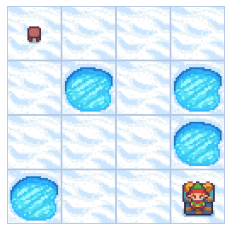

In [ ]:
# Print sequence of actions that has taken to reach the goal
# Any visualization for further intuition would be appreciated.
import time
from IPython import display
# here we display a sequence of actions that results achiving the goal.
env.reset()

action_seq= []
done = False
r = 0
while not done:
  action = np.argmax(Q[state, :])
  new_state, reward, done, _ = env.step(action)
  r+= reward
  state = new_state 
  action_seq.append(Actions[action])

  env_screen = env.render(mode = 'rgb_array')
  plt.imshow(env_screen)
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  time.sleep(0.5)


print(' --> '.join(action_seq))


Text(0.5, 1.0, 'chosen action in each state')

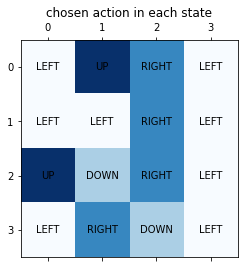

In [ ]:
# visualizing action it should take
Q_max = np.argmax(Q,axis = 1)
Q_max = np.reshape(Q_max,(4,4))
fig, ax = plt.subplots()



ax.matshow(Q_max, cmap=plt.cm.Blues)
for i in range(4):
    for j in range(4):
        c = Actions[Q_max[j,i]]
        ax.text(i, j, str(c), va='center', ha='center')
plt.title('chosen action in each state')



so based on action, first it choose to go left because it's slipery it has 0.33 chance to go down and 0.66 stay where he is standing right now, then choose another left in hope to go one house down, now it choose up so it either go up or right(so it doesn't fall) if it goes right, then it choose down if it goes down then it shoud go right and finally select down so it doesn't go up, but as we see in (3,4) it choos right, there it is a 0.33 that it falls so it doesn't learned that step correctly.

but overall if everything goes perfect it should choose :


Left-Left-Up-Down-Right-Down 


displaying path as a videos

In [ ]:
#we use codes that is used in part two (cartpole) to save as videos
!sudo apt-get update
!pip install 'imageio==2.4.0'
!sudo apt-get install -y xvfb ffmpeg
import IPython
import base64

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu focal InRelease
Get:3 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:6 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:12 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Hit:14 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal InRe

In [ ]:
def embed_mp4(filename):
  
    video = open(filename,'rb').read()
    b64 = base64.b64encode(video)
    tag = '''
    <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
    Your browser does not support the video tag.
    </video>'''.format(b64.decode())
    
    return IPython.display.HTML(tag)

In [ ]:
def create_policy_eval_video(env, Q, filename, num_episodes=1, fps=10):
  
    filename = filename + ".mp4"
    with imageio.get_writer(filename, fps=fps) as video:
        for _ in range(num_episodes):
            state = env.reset()
            video.append_data(env.render(mode = 'rgb_array'))
            while True:
                action = np.argmax(Q_sarsa[state, :])
                new_state, reward, done, _ = env.step(action)
                state = new_state
                env_screen = env.render(mode = 'rgb_array')
                video.append_data(env_screen)
                if done:
                    break
    return embed_mp4(filename)

In [ ]:
import math
import base64
import random
import imageio
import IPython
import matplotlib
from itertools import count
import matplotlib.pyplot as plt
from collections import namedtuple, deque

create_policy_eval_video(env, Q, "Q Learning")

/usr/local/lib/python3.9/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(
/usr/local/lib/python3.9/dist-packages/imageio/plugins/ffmpeg.py:727: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  self._proc.stdin.write(im.tostring())


## SARSA
SARSA (State-Action-Reward-State-Action) is a popular reinforcement learning algorithm used for finding an optimal policy in an environment. Like Q-learning, SARSA is an off-policy algorithm that updates the values of the Q-table based on the observed rewards and next state-action pairs.

The key difference between SARSA and Q-learning is in the selection of the next action. In SARSA, the next action is selected based on the current policy, whereas in Q-learning, the next action is selected based on the greedy policy. This means that in SARSA, the algorithm is learning about the expected returns from the current policy, whereas in Q-learning, the algorithm is learning about the optimal policy.

Mathematically, the SARSA update rule can be represented as:

$$Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \alpha \left( R_{t+1} + \gamma Q(S_{t+1},A_{t+1}) - Q(S_t,A_t) \right)$$


Where $Q(S_t,A_t)$ is the current estimate of the expected return for taking action $A_t$ in state $S_t$, $\alpha$ is the learning rate, $R_{t+1}$ is the reward received after taking action $A_t$ in state $S_t$, $\gamma$ is the discount factor, and $Q(S_{t+1},A_{t+1})$ is the estimated return for taking action $A_{t+1}$ in the next state $S_{t+1}$.


In [ ]:
def sarsa(env, num_episodes, alpha, gamma, epsilon):
    # our aproch for sarsa is very similar to Q learning, main difference is when we want to update Q value
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    r_list = [] # this two are two new outputs that we store len of episode and sum of rewards in each episode in them(reward is spare so output is either 0 or zero)
    episode_len_list = []
    for episode in tqdm(range(num_episodes)):
        reward_episode = 0
        counter_len_episode = 0
        state = env.reset()
        action_selected_max = np.argmax(Q[state,:])
        epsilon = 0.5
        max_prob = 1 - epsilon + epsilon/(env.action_space.n)
        sample_prob = epsilon/(env.action_space.n)*np.ones((4,))
        sample_prob[action_selected_max] = max_prob
        action = np.random.choice(action_space_all, p=sample_prob )#initial action based on epsilon greedy method
        # ==================================== Your Code (Begin) ====================================
        while(True):
          
          # so now we sampled our action with epsilon-greedy policy, we should update our Q value based on it
          state_prime,r,terminate_flag,_ = env.step(action)
          reward_episode += r
          counter_len_episode += 1
          action_selected_max_prime = np.argmax(Q[state_prime,:])
          sample_prob_prime = epsilon/(env.action_space.n)*np.ones((4,))
          sample_prob_prime[action_selected_max_prime] = max_prob
          action_prime = np.random.choice(action_space_all, p=sample_prob_prime ) # choosing next action with epsilon greedy policy
          Q[state,action] = Q[state,action] + alpha*(r + gamma*Q[state_prime,action_prime] -  Q[state,action]) # we update Q value based on our policy for action in next state
          # update state
          state = state_prime
          action = action_prime # updating action
          # check if we should terminate process
          if terminate_flag:
            r_list.append(reward_episode)
            episode_len_list.append(counter_len_episode)
            break

        # ==================================== Your Code (End) ====================================
        
    return Q,r_list,episode_len_list

In [ ]:
# change the parameters if needed
n_episodes = 3000
alpha = 0.1 
gamma = 0.9
epsilon=0.5

In [ ]:
Q_sarsa,r_list_Sarsa,episode_len_list_sarsa = sarsa(env, num_episodes, alpha, gamma, epsilon)#we changed output name to Q_sarsa so we don't overwrite Q of Q learning

state = env.reset()
done = False
while not done:
    action = np.argmax(Q_sarsa[state, :])
    new_state, reward, done, _ = env.step(action)
    state = new_state
    if done:
        if reward == 1:
            print("Successful episode!")
        else:
            print("Failed episode")

100%|██████████| 3000/3000 [00:02<00:00, 1283.69it/s]

Successful episode!


LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> LEFT --> UP --> LEFT --> LEFT --> UP --> UP --> LEFT --> LEFT --> LEFT --> LEFT --> UP --> DOWN --> RIGHT --> DOWN


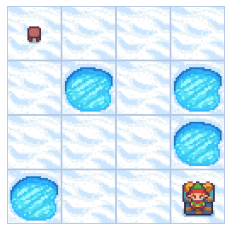

In [ ]:
# Print sequence of actions that has taken to reach the goal
# Any visualization for further intuition would be appreciated.
env.reset()

action_seq= []
done = False
r = 0
while not done:
  action = np.argmax(Q_sarsa[state, :])
  new_state, reward, done, _ = env.step(action)
  r+= reward
  state = new_state 
  action_seq.append(Actions[action])

  env_screen = env.render(mode = 'rgb_array')
  plt.imshow(env_screen)
  plt.axis('off')
  display.display(plt.gcf())
  display.clear_output(wait=True)
  time.sleep(0.2)


print(' --> '.join(action_seq))

Text(0.5, 1.0, 'chosen action in each state')

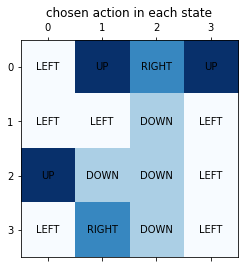

In [ ]:
# visualizing action it should take
Q_max = np.argmax(Q_sarsa,axis = 1)
Q_max = np.reshape(Q_max,(4,4))
fig, ax = plt.subplots()



ax.matshow(Q_max, cmap=plt.cm.Blues)
for i in range(4):
    for j in range(4):
        c = Actions[Q_max[j,i]]
        ax.text(i, j, str(c), va='center', ha='center')
plt.title('chosen action in each state')



as we can see, generally its same as Q learning matrix, but index (3,4) is different here, now it learns to go down, it is still risky (it should go left to be totally safe) but it is much better so if everything goes perfect chosen actions should be somehting like:

Left-Left-Up-Down-Right-Down 

reminder: because environment is slippery, when for example in (1,1) we say go left it has 0.33 chance to go down, 0.33 left(but because left is blocked it remain in same block) and 0.33 to go up(this path is also blocked)

In [ ]:
create_policy_eval_video(env, Q_sarsa, "Q Sarsa")

## Conclution
Compare these 2 methods based on average return, penalty, episode length and success rate.
In the previous cells, if necessary, store the necessary variables for this comparison and use them in the following block.

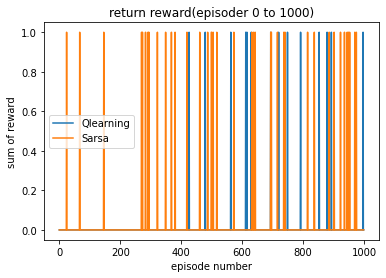

In [ ]:
# we can compare result in two different states, first we can compare return of this two algorithm we we are leargnin respective Q matrixes, second, we
# can use final policy in each method and run them 1000 times then compare said parameters
# first we compare results when Q matrix is begin updated
plt.figure()
plt.plot(range(0, 1000),r_list_Qlearning[0:1000])
plt.plot(range(0, 1000),r_list_Sarsa[0:1000])
plt.title('return reward(episoder 0 to 1000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

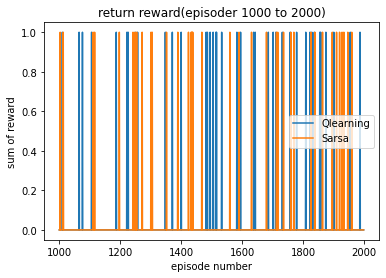

In [ ]:
plt.figure()
plt.plot(range(1000, 2000),r_list_Qlearning[1000:2000])
plt.plot(range(1000, 2000),r_list_Sarsa[1000:2000])
plt.title('return reward(episoder 1000 to 2000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

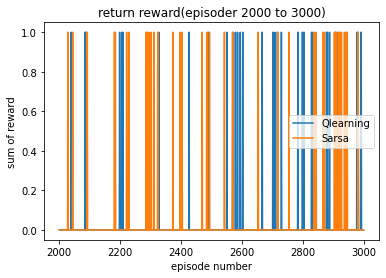

In [ ]:
plt.figure()
plt.plot(range(2000, 3000),r_list_Qlearning[2000:3000])
plt.plot(range(2000, 3000),r_list_Sarsa[2000:3000])
plt.title('return reward(episoder 2000 to 3000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

we also plot return reward with discount factor

In [ ]:
r_list_Qlearning = np.asarray(r_list_Qlearning)
episode_len_list_Qlearning = np.asarray(episode_len_list_Qlearning)
r_list_Sarsa = np.asarray(r_list_Sarsa)
episode_len_list_sarsa = np.asarray(episode_len_list_sarsa)
score_Q_discounter = np.zeros((3000,))
score_Sarsa_discounter = np.zeros((3000,))
for i in range(3000):
  score_Q_discounter[i] = r_list_Qlearning[i]*(gamma**(episode_len_list_Qlearning[i]-1))
  score_Sarsa_discounter[i] = r_list_Sarsa[i]*(gamma**(episode_len_list_sarsa[i]-1))



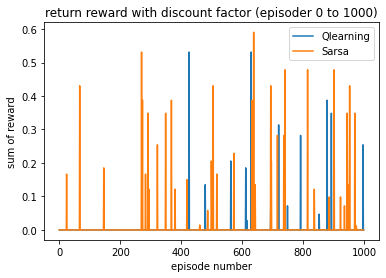

In [ ]:
plt.figure()
plt.plot(range(0, 1000),score_Q_discounter[0:1000])
plt.plot(range(0, 1000),score_Sarsa_discounter[0:1000])
plt.title('return reward with discount factor (episoder 0 to 1000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

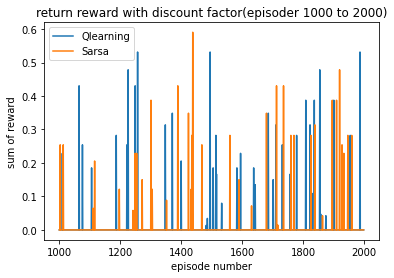

In [ ]:
plt.figure()
plt.plot(range(1000, 2000),score_Q_discounter[1000:2000])
plt.plot(range(1000, 2000),score_Sarsa_discounter[1000:2000])
plt.title('return reward with discount factor(episoder 1000 to 2000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

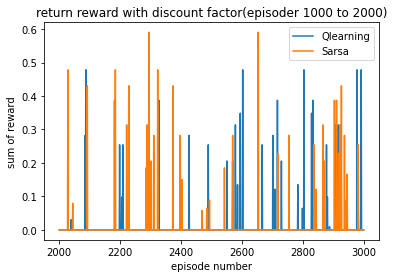

In [ ]:
plt.figure()
plt.plot(range(2000, 3000),score_Q_discounter[2000:3000])
plt.plot(range(2000, 3000),score_Sarsa_discounter[2000:3000])
plt.title('return reward with discount factor(episoder 1000 to 2000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

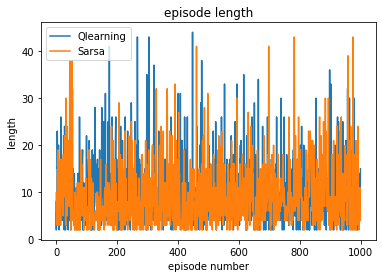

In [ ]:
plt.figure()
plt.plot(range(0000, 1000),episode_len_list_Qlearning[0000:1000])
plt.plot(range(0000, 1000),episode_len_list_sarsa[0000:1000])
plt.title('episode length')
plt.xlabel('episode number')
plt.ylabel('length')
plt.legend(['Qlearning', 'Sarsa'])

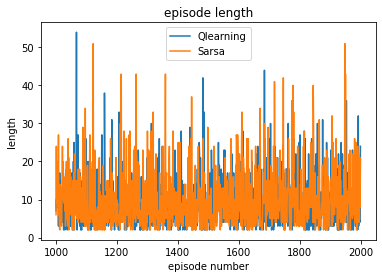

In [ ]:
plt.figure()
plt.plot(range(1000, 2000),episode_len_list_Qlearning[1000:2000])
plt.plot(range(1000, 2000),episode_len_list_sarsa[1000:2000])
plt.title('episode length')
plt.xlabel('episode number')
plt.ylabel('length')
plt.legend(['Qlearning', 'Sarsa'])

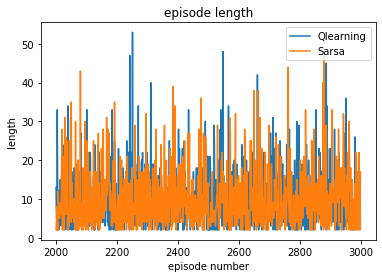

In [ ]:
plt.figure()
plt.plot(range(2000, 3000),episode_len_list_Qlearning[2000:3000])
plt.plot(range(2000, 3000),episode_len_list_sarsa[2000:3000])
plt.title('episode length')
plt.xlabel('episode number')
plt.ylabel('length')
plt.legend(['Qlearning', 'Sarsa'])

In [ ]:

average_return_Q = np.mean(score_Q_discounter)
success_rate_Q = sum(r_list_Qlearning)/3000
mean_episode_Q = np.mean(episode_len_list_Qlearning)
mean_episode_success = np.mean(episode_len_list_Qlearning[r_list_Qlearning == 1])
print(f"average return in Q learning = {average_return_Q}")
print(f"success rate in Q learning = {success_rate_Q}")
print(f"average of lengt of all episodes = {mean_episode_Q}")
print(f"average of lengt of success episodes = {mean_episode_success}")


average return in Q learning = 0.007657878133987584
success rate in Q learning = 0.029
average of lengt of all episodes = 9.633666666666667
average of lengt of success episodes = 15.931034482758621


In [ ]:
average_return_sarsa = np.mean(score_Sarsa_discounter)
success_rate_sarsa = sum(r_list_Sarsa)/3000
mean_episode_sarsa = np.mean(episode_len_list_sarsa)
mean_episode_success = np.mean(episode_len_list_sarsa[r_list_Sarsa == 1])
print(f"average return in SARSA = {average_return_sarsa}")
print(f"success rate in SARSA= {success_rate_sarsa}")
print(f"average of lengt of all episodes Sarsa = {mean_episode_sarsa}")
print(f"average of lengt of success episodes Sarsa = {mean_episode_success}")


average return in SARSA = 0.01030656004084368
success rate in SARSA= 0.039
average of lengt of all episodes Sarsa = 9.793666666666667
average of lengt of success episodes Sarsa = 15.803418803418804


so based on this, in this example sarsa performs better, it may be because in Q learning we always see best possible outcome in next state, but because environment is very random (%66 probability of other actions), it causes to our performance drops,especially in first episodes where our estimation of Q is not good.
now lets run final policy for 1000 episode and compare result again

In [ ]:
r_list_Qlearningf = []
episode_len_list_Qlearningf = []
r_list_Sarsaf = []
episode_len_list_sarsaf = []

for i in range(1000):
  len_episode = 0
  env.reset()

  action_seq= []
  done = False
  r = 0
  while not done:
    action = np.argmax(Q[state, :])
    new_state, reward, done, _ = env.step(action)
    r+= reward
    len_episode+= 1
    state = new_state 
  r_list_Qlearningf.append(r)
  episode_len_list_Qlearningf.append(len_episode)
for i in range(1000):
  len_episode = 0
  env.reset()

  action_seq= []
  done = False
  r = 0
  while not done:
    action = np.argmax(Q_sarsa[state, :])
    new_state, reward, done, _ = env.step(action)
    r+= reward
    len_episode+= 1
    state = new_state 
  r_list_Sarsaf.append(r)
  episode_len_list_sarsaf.append(len_episode)



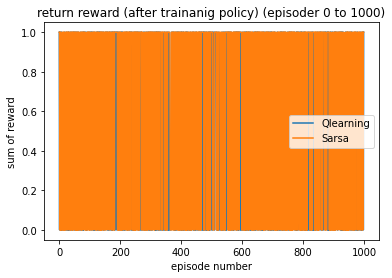

In [ ]:
plt.figure()
plt.plot(range(0, 1000),r_list_Qlearningf[0:1000])
plt.plot(range(0, 1000),r_list_Sarsaf[0:1000])
plt.title('return reward (after trainanig policy) (episoder 0 to 1000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

In [ ]:
r_list_Qlearningf = np.asarray(r_list_Qlearningf)
episode_len_list_Qlearningf = np.asarray(episode_len_list_Qlearningf)
r_list_Sarsaf = np.asarray(r_list_Sarsaf)
episode_len_list_sarsaf = np.asarray(episode_len_list_sarsaf)
score_Q_discounterf = np.zeros((1000,))
score_Sarsa_discounterf = np.zeros((1000,))
for i in range(1000):
  score_Q_discounterf[i] = r_list_Qlearningf[i]*(gamma**(episode_len_list_Qlearningf[i]-1))
  score_Sarsa_discounterf[i] = r_list_Sarsaf[i]*(gamma**(episode_len_list_sarsaf[i]-1))



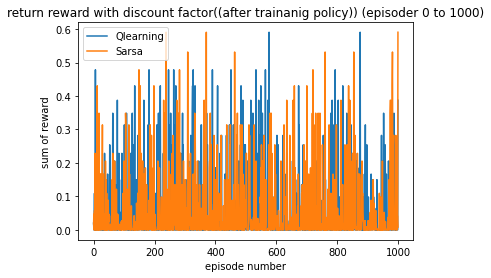

In [ ]:
plt.figure()
plt.plot(range(0, 1000),score_Q_discounterf[0:1000])
plt.plot(range(0, 1000),score_Sarsa_discounterf[0:1000])
plt.title('return reward with discount factor((after trainanig policy)) (episoder 0 to 1000)')
plt.xlabel('episode number')
plt.ylabel('sum of reward')
plt.legend(['Qlearning', 'Sarsa'])

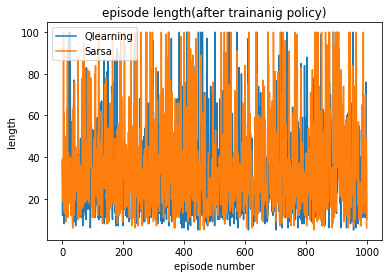

In [ ]:
plt.figure()
plt.plot(range(0000, 1000),episode_len_list_Qlearningf[0000:1000])
plt.plot(range(0000, 1000),episode_len_list_sarsaf[0000:1000])
plt.title('episode length(after trainanig policy)')
plt.xlabel('episode number')
plt.ylabel('length')
plt.legend(['Qlearning', 'Sarsa'])

In [ ]:
print('after learning policy for Q learning we have')

average_return_Q = np.mean(score_Q_discounterf)
success_rate_Q = sum(r_list_Qlearningf)/1000
mean_episode_Q = np.mean(episode_len_list_Qlearningf)
mean_episode_success = np.mean(episode_len_list_Qlearningf[r_list_Qlearningf == 1])
print(f"average return in Q learning = {average_return_Q}")
print(f"success rate in Q learning = {success_rate_Q}")
print(f"average of lengt of all episodes = {mean_episode_Q}")
print(f"average of lengt of success episodes = {mean_episode_success}")


after learning policy for Q learning we have
average return in Q learning = 0.0616162279508572
success rate in Q learning = 0.499
average of lengt of all episodes = 31.596
average of lengt of success episodes = 30.809619238476955


In [ ]:
print('after learning policy for Sarsa we have')

average_return_sarsa = np.mean(score_Sarsa_discounterf)
success_rate_sarsa = sum(r_list_Sarsaf)/1000
mean_episode_sarsa = np.mean(episode_len_list_sarsaf)
mean_episode_success = np.mean(episode_len_list_sarsaf[r_list_Sarsaf == 1])
print(f"average return in SARSA = {average_return_sarsa}")
print(f"success rate in SARSA= {success_rate_sarsa}")
print(f"average of lengt of all episodes Sarsa = {mean_episode_sarsa}")
print(f"average of lengt of success episodes Sarsa = {mean_episode_success}")


after learning policy for Sarsa we have
average return in SARSA = 0.05920270904884028
success rate in SARSA= 0.591
average of lengt of all episodes Sarsa = 37.143
average of lengt of success episodes Sarsa = 35.2994923857868


as we can see, Q learning is more likely to fail task but do it faster, on the other hand Sarsa takes the safer approch but it is slower so average score is less in sarsa compared to Q learning.
the reason of this difference is when we learn based on Q learning, we always assume thate in next state we take best action, so we may choose a more risky path but it result to achive our goal faster but in SARSA we always use our current policy so it takes a less risky approch so episodes length becomes longer

<br><br><br><br><br><br><br><br><br><br><br><br>

# 2. Monte Carlo method

In this notebook, you will learn about the Monte Carlo method in the context of reinforcement learning.
Your agent will move in the following picture. This is a random walk with two possible actions (`LEFT` and `RIGHT`).
The agent gets a reward of 1 if it reaches the right-most state, and 0 otherwise. You are going to use such an environment with 31 states.

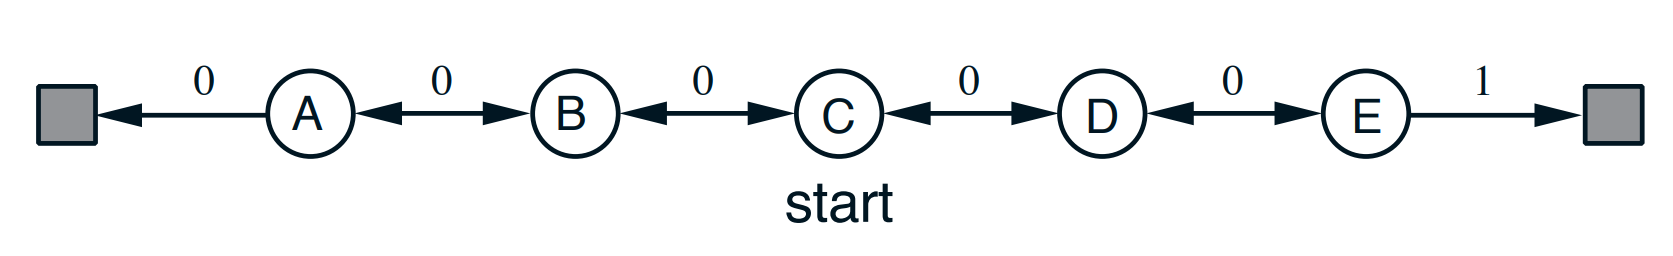

In [1]:
class RandomWalkEnv():
    def __init__(self, num_states=31, start=15, gamma=1):
        self.num_states = num_states
        self.start = start
        self.end = num_states - 1
        self.gamma = gamma
        self.state = None
        self.actions = ['LEFT', 'RIGHT']

    def reset(self):
        self.state = self.start
        return self.state, 0, False

    def step(self, action):
        if self.state == self.end or self.state == 0:
            return self.state, 0, True
        action_direction = 0
        if action == 'RIGHT':
            action_direction = 1
        elif action == 'LEFT':
            action_direction = -1

        self.state += action_direction
        reward, done = 0, False
        if self.state == self.end:
            reward, done = 1, True
        elif self.state == 0:
            done = True
        return self.state, reward, done

    def get_true_values(self):
        values = [0] * self.num_states
  
        values[self.end - 1] = 1
        for i in range(self.end - 1, 1, -1):
            values[i - 1] = self.gamma * values[i]
        
        return values

The Monte Carlo method is a reinforcement learning technique for estimating the value function of a Markov decision process (MDP). It involves generating multiple episodes by following a given policy and computing the returns (sum of rewards) for each state-action pair. The value of a state-action pair is then estimated as the average of the returns obtained from that pair over multiple episodes.

The formula for updating the value function using the Monte Carlo method is:

\begin{equation}
Q(S_t,A_t) \leftarrow Q(S_t,A_t) + \frac{1}{N(S_t,A_t)} \sum_{i=1}^{N(S_t,A_t)}(G_i - Q(S_t,A_t))
\end{equation}

where $Q(S_t,A_t)$ is the estimated value of the state-action pair $(S_t,A_t)$, $N(S_t,A_t)$ is the number of times the state-action pair has been visited, $G_i$ is the return obtained from the $i$th visit to the state-action pair, and the sum is taken over all $N(S_t,A_t)$ visits.

To implement the Monte Carlo method, you need to define the environment, the policy, and the number of episodes to simulate. At each step of the episode, you observe the state, take an action according to the policy, and observe the reward and the next state. You then update the value function using the formula above. As more episodes are generated, the value estimates become more accurate.

## **Important note:(added comment)**


 we can simplify given formula in various ways, first we know that policy remains random so Q(st,at) is constain so we have:
  

```
   Q <- Q + (1/N)(sigma(G - Q)) =
   Q + (1/N)(sigma(G)) - N*(1/N)*Q =
   Q-Q + (1/N)(sigma(G)) =
    (1/N)*sigma(G) =
     alpha*sigma(G)
```


 also another way to compute Q is based on lecture notes like:
    # Q <- Q + alpha(G-Q)
 which is incremental monte carlo

first we compute second method and plot result, then we compute Q based alpha*sigma(G) and compare result

In [28]:
def MC(env, num_episodes, alpha=0.1):
    # ==================================== Your Code (Begin) ====================================
    
    values = np.zeros((env.num_states,num_episodes))
    errors = np.zeros((num_episodes,))
    Q = np.zeros((env.num_states,len(env.actions)))
    N = np.zeros((env.num_states,len(env.actions)))
    G = np.zeros((env.num_states,len(env.actions),num_episodes)) # we save sume of rewards in each episode for each state
    
    state,_,_ = env.reset()
    action_space_all = np.array([0,1])
    ind_2_action =  {0: 'LEFT', 1: 'RIGHT'}


   
    # we should use epsilon-greedy method for sampling our action
    
    for episode in (range(num_episodes)):
      state,_,_ = env.reset()

      flag_QA = np.zeros((env.num_states,len(env.actions)))
      state_list = []
      action_list = []
      reward_list = []
      #sampling
      while(True):
        sample_prob = 1/(len(env.actions))*np.ones((len(env.actions),))
      #  sample_prob[max_action_all] = max_prob
        action = np.random.choice(action_space_all, p=sample_prob )
        # so now we sampled our action with epsilon-greedy policy, we should update our Q value based on it
        state_prime,r,terminate_flag = env.step(ind_2_action[action])
        state_list.append(state)
        action_list.append(action)
        reward_list.append(r)
        state = state_prime
        # check if we should terminate process
        if terminate_flag:
          break
      state_arr = np.asarray(state_list)
      action_arr = np.asarray(action_list)
      reward_arr = np.asarray(reward_list)
      for i in range(len(state_arr)):
        if(flag_QA[state_arr[i],action_arr[i]] == 0): # we use first visit monte carlo, so 
          flag_QA[state_arr[i],action_arr[i]] = 1
          G_temp = np.sum(reward_arr[i:])
          G[state_arr[i],action_arr[i],int(N[state_arr[i],action_arr[i]])] = G_temp
          N[state_arr[i],action_arr[i]] += 1
         
          Q[state_arr[i],action_arr[i]] = Q[state_arr[i],action_arr[i]]+  (alpha)*(G_temp -Q[state_arr[i],action_arr[i]] )
      values_episode = np.max(Q,axis = 1)
      values[:,episode] = values_episode
      V_true = env.get_true_values()
      errors[episode] = np.sqrt(np.square(np.subtract(V_true,values_episode)).mean())

    # ==================================== Your Code (End) ====================================
    return values, errors

100%|██████████| 5/5 [08:22<00:00, 100.42s/it]


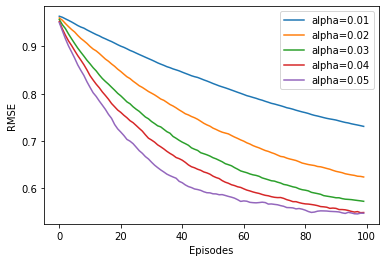

In [29]:
# Visualization

import matplotlib.pyplot as plt
from tqdm import tqdm
env = RandomWalkEnv()
num_episodes = 100
alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
num_runs = 100
V_final = np.zeros((31,5))
counter = 0
for alpha in tqdm(alphas):
    rmse_avg = np.zeros(num_episodes)
    for run in range(num_runs):
        values, errors = MC(env, num_episodes, alpha)
        rmse_avg += np.array(errors)
    rmse_avg /= num_runs
    V_final[:,counter] = values[:,99]
    plt.plot(range(num_episodes), rmse_avg, label=f'alpha={alpha}')
    counter += 1
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('RMSE')
plt.show()

# Any visualization for better intuition would be appreciated.

Text(0.5, 1.0, 'change in values for different alpha')

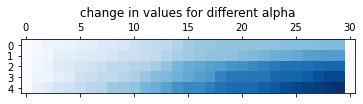

In [30]:
fig, ax = plt.subplots()

V_final_t = V_final.T

ax.matshow(V_final.T, cmap=plt.cm.Blues)
plt.title('change in values for different alpha')


we see ass alpha increase, estimation becomses more accurate( it should be same vlaue(1) for 1 to 30 and zero for 0 and 31 

In [25]:
def MC_2(env, num_episodes, alpha=0.1):
    # ==================================== Your Code (Begin) ====================================
    values = np.zeros((env.num_states,num_episodes))
    errors = np.zeros((num_episodes,))
    Q = np.zeros((env.num_states,len(env.actions)))
    N = np.zeros((env.num_states,len(env.actions)))
    G = np.zeros((env.num_states,len(env.actions),num_episodes)) # we save sume of rewards in each episode for each state
    
    state,_,_ = env.reset()
    action_space_all = np.array([0,1])
    ind_2_action =  {0: 'LEFT', 1: 'RIGHT'}


   
    # we should use epsilon-greedy method for sampling our action
    
    for episode in (range(num_episodes)):
      state,_,_ = env.reset()

      flag_QA = np.zeros((env.num_states,len(env.actions)))
      state_list = []
      action_list = []
      reward_list = []
      #sampling
      while(True):
        sample_prob = 1/(len(env.actions))*np.ones((len(env.actions),))
      #  sample_prob[max_action_all] = max_prob
        action = np.random.choice(action_space_all, p=sample_prob )
        # so now we sampled our action with epsilon-greedy policy, we should update our Q value based on it
        state_prime,r,terminate_flag = env.step(ind_2_action[action])
        state_list.append(state)
        action_list.append(action)
        reward_list.append(r)
        state = state_prime
        # check if we should terminate process
        if terminate_flag:
          break
      state_arr = np.asarray(state_list)
      action_arr = np.asarray(action_list)
      reward_arr = np.asarray(reward_list)
      for i in range(len(state_arr)):
        if(flag_QA[state_arr[i],action_arr[i]] == 0): # we use first visit monte carlo, so 
          flag_QA[state_arr[i],action_arr[i]] = 1
          G_temp = np.sum(reward_arr[i:])
          G[state_arr[i],action_arr[i],int(N[state_arr[i],action_arr[i]])] = G_temp
          N[state_arr[i],action_arr[i]] += 1
         
          Q[state_arr[i],action_arr[i]] = (alpha)*(np.sum(G[state_arr[i],action_arr[i],0:int(N[state_arr[i],action_arr[i]])]))
      values_episode = np.max(Q,axis = 1)
      values[:,episode] = values_episode
      V_true = env.get_true_values()
      errors[episode] = np.sqrt(np.square(np.subtract(V_true,values_episode)).mean())

    # ==================================== Your Code (End) ====================================
    return values, errors

100%|██████████| 5/5 [07:57<00:00, 95.56s/it]


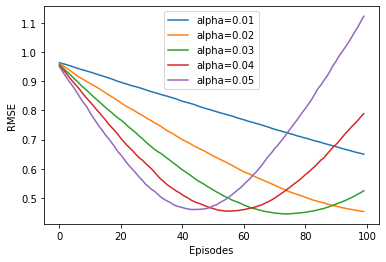

In [26]:
# Visualization

import matplotlib.pyplot as plt

env = RandomWalkEnv()
num_episodes = 100
alphas = [0.01, 0.02, 0.03, 0.04, 0.05]
num_runs = 100
V_final = np.zeros((31,5))
counter = 0
for alpha in tqdm(alphas):
    rmse_avg = np.zeros(num_episodes)
    for run in range(num_runs):
        values, errors = MC_2(env, num_episodes, alpha)
        rmse_avg += np.array(errors)
    V_final[:,counter] = values[:,99]

    rmse_avg /= num_runs
    plt.plot(range(num_episodes), rmse_avg, label=f'alpha={alpha}')
    counter += 1
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('RMSE')
plt.show()

# Any visualization for better intuition would be appreciated.

Text(0.5, 1.0, 'change in values for different alpha')

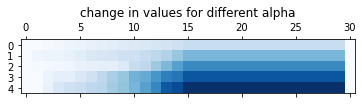

In [27]:
fig, ax = plt.subplots()

V_final_t = V_final.T

ax.matshow(V_final.T, cmap=plt.cm.Blues)
plt.title('change in values for different alpha')


so as we can see, in incremental mode we always get a better result it's because that even when we choose a big value for alpha, we update values with slow rate so it doesn't exceed the sum of reward values (1) and so result becomes better.
but in second method we are estimating (1/N) with a constant, so when we use more episodes than 1/alpha we are at risk that our values exceed real values(it becomes larger than one) and so it causes in increase of error, but with good ration between chosen alpha and number of episodes, we can achive better results than incremental method